In [1]:
import jax.numpy as jnp
import jax
from einops import rearrange
import matplotlib.pyplot as plt

In [2]:
H = 12.0 #in.
W = 27.0 #in.
μ = 0.5 #Poisson's ratio for natural rubber 

a = -2.0 #displacement at top of bearing, plane A-A-A-A
b = -μ * a #displacement at side of bearing, plane B-B-B-B
c = -μ * a #displacement at front of bearing, plane A-A-B-B

# HW 1: Elastomeric Bridge Bearing Deformation Fields and Strains
**Name:** Xiangdong Yang  
**Date:** Aug 28, 2025

The code of this homework is written in python with jax.

## 1 Develop a displacement field equation for deformation in the w direction
As in the u direction, I can put:
$$
w(x,y,z)=c\cdot\sin(\frac{\pi\cdot y}{H})\cdot \frac{2}{W}\cdot(z-\frac{W}{2})
$$
where $c=b=\mu \cdot a$.

## 2&3 Calculate the gradients of the deformation field and the strain tensor at any point
### (2&3).1 Calculate u, v, and w 
I first write functions for u, v, and w separately, with help of the equations I already have for them.

In [3]:
def u(point):
    return b*jnp.sin(jnp.pi*point[1]/H)*1/(W/2)*(point[0]-W/2)

def v(point):
    return a/H*point[1]

def w(point):
    return c*jnp.sin(jnp.pi*point[1]/H)*1/(W/2)*(point[2]-W/2)

### (2&3).2 Obtain the deformation field, deformation gradient, and strain tensor
From the above functions, I can construct the function for the deformation field, which is
$$
\nu(x,y,z)=
\begin{Bmatrix}
u(x,y,z)\\
v(x,y,z)\\
w(x,y,z)
\end{Bmatrix}
$$
The deformation gradient is the Jacobian of $\nu$, which can be calculated using the jax.jacfwd() function.

The stress tensor $\varepsilon$ as shown in the screenshot can be calculated as:
$$
\varepsilon=\frac{1}{2}\cdot(J_\nu+J^T_\nu)
$$
where $J_\nu$ denotes the Jacobian of $\nu$, and $J_\nu^T$ its transpose.

In [4]:
@jax.jit
def deformation_field(point):
    return jnp.array([u(point), v(point), w(point)])

@jax.jit
def deformation_gradient(point):
    return jax.jacfwd(deformation_field)(point)

@jax.jit
def grad2tensor(point):
    grad=deformation_gradient(point)
    return 0.5 * (grad + grad.T)

### (2&3).3 Calculate the deformation and strain at a meshgrid of points
I generate a meshgrid of points at the original shape and evaluate the deformation field function and the strain tensor function on them. The deformed shape is obtained by adding the deformation to the original shape, which I can later plot.

In [5]:
nx=50
ny=50
nz=50

meshgrid = jnp.array(jnp.meshgrid(jnp.linspace(0, W, nx), jnp.linspace(0, H, ny), jnp.linspace(0, W, nz)))
meshgrid = rearrange(meshgrid, 'd x y z -> (x y z) d')
deformations = jax.vmap(deformation_field)(meshgrid)
deformed_shape = meshgrid + deformations
strain_tensor = jax.vmap(grad2tensor)(meshgrid)

Here I choose a random point in space and print the results of the deformation field and strain tensor

In [6]:
key = jax.random.PRNGKey(0)
randompoint = jax.random.uniform(key, (3,), minval=jnp.array([0.0, 0.0, 0.0]), maxval=jnp.array([W, H, W]))
print("Random point in bearing: ", randompoint)
print("\nDeformation at random point: ", deformation_field(randompoint))
print("\nStrain tensor at random point: \n", grad2tensor(randompoint)) 

Random point in bearing:  [25.58701  11.742958  8.97187 ]

Deformation at random point:  [ 0.06020453 -1.9571598  -0.02255429]

Strain tensor at random point: 
 [[ 0.00498093 -0.11693369  0.        ]
 [-0.11693369 -0.16666667  0.04380661]
 [ 0.          0.04380661  0.00498093]]


## 4 Plot the 3D deformed shape
Plot the 3D deformed shape with matplotlib using our results above. For better reference, I also plot the front, side, and top views of the deformed shape.

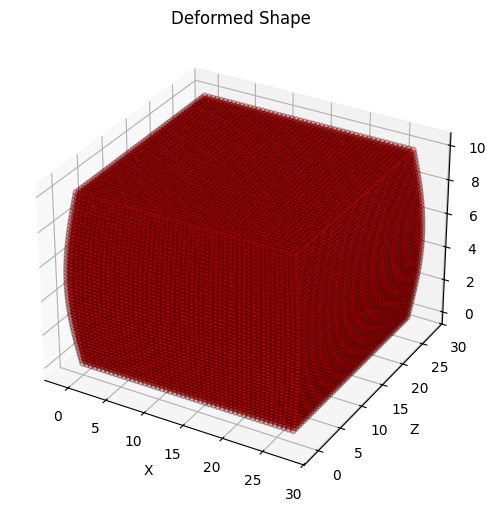

In [7]:
# --- Deformed ---
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(projection='3d')

ax1.scatter(deformed_shape[:,0],
            deformed_shape[:,2],
            deformed_shape[:,1],
            alpha=0.3,color="red", edgecolor="black")

ax1.set_title("Deformed Shape")
ax1.set_xlabel("X")
ax1.set_ylabel("Z")
ax1.set_zlabel("Y")
plt.show()


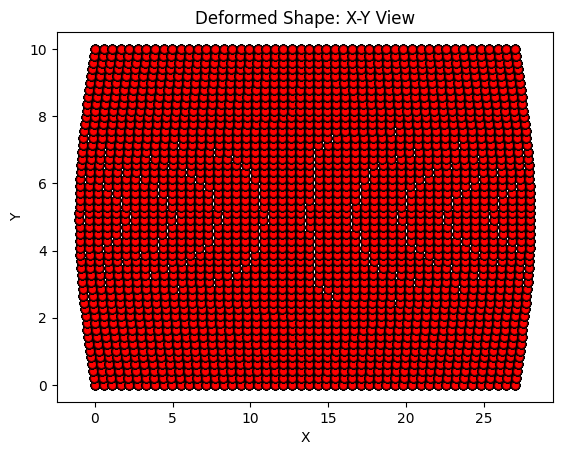

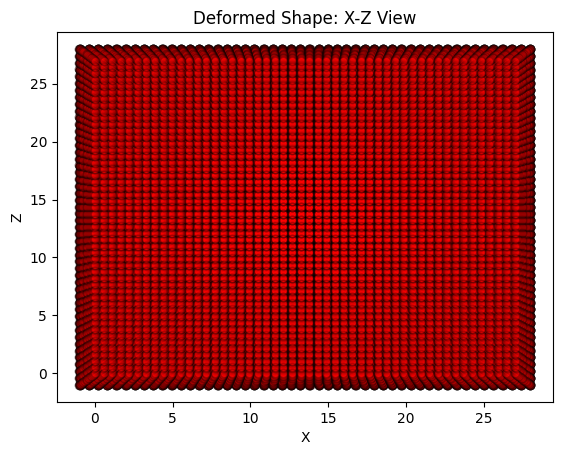

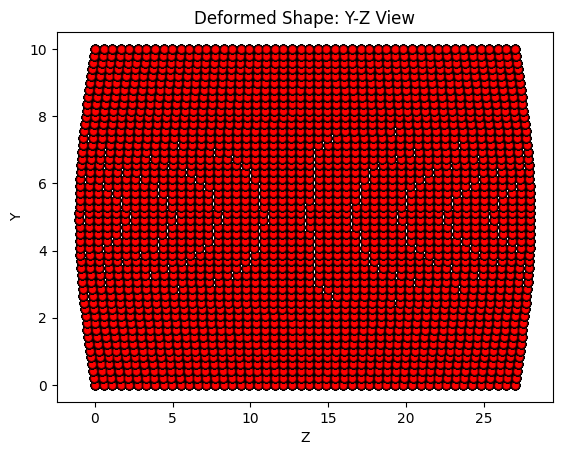

In [8]:
plt.figure()
plt.scatter(deformed_shape[:,0], deformed_shape[:,1],
            alpha=0.3,color="red", edgecolor="black")

plt.title("Deformed Shape: X-Y View")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

plt.figure()
plt.scatter(deformed_shape[:,0], deformed_shape[:,2],
            alpha=0.3,color="red", edgecolor="black")       
plt.title("Deformed Shape: X-Z View")
plt.xlabel("X")
plt.ylabel("Z")
plt.show() 

plt.figure()
plt.scatter(deformed_shape[:,2], deformed_shape[:,1],
            alpha=0.3,color="red", edgecolor="black")
plt.title("Deformed Shape: Y-Z View")
plt.xlabel("Z")
plt.ylabel("Y")
plt.show()

## 5 Plot the 3D strain field contours

Plot the 3D strain field contours with matplotlib using the strain tensor calculated above. Interestingly, for all points I have:
$$
\varepsilon_{yy}=\frac{a}{H}=-1.667
$$
$$
\gamma_{xz}=0
$$

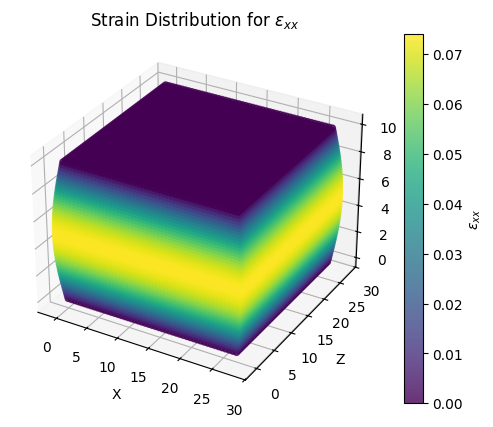

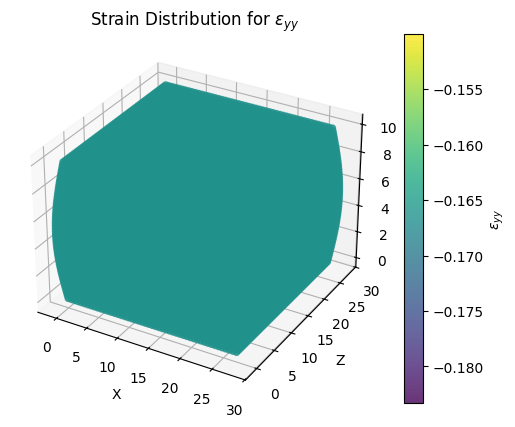

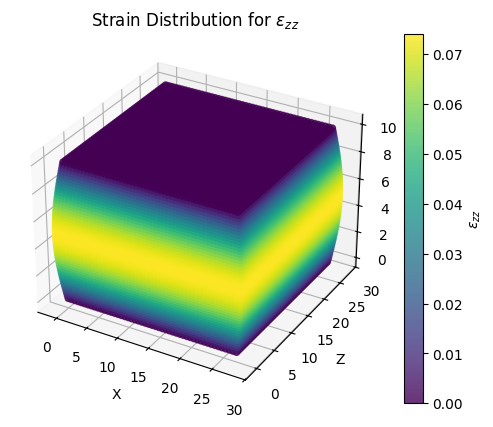

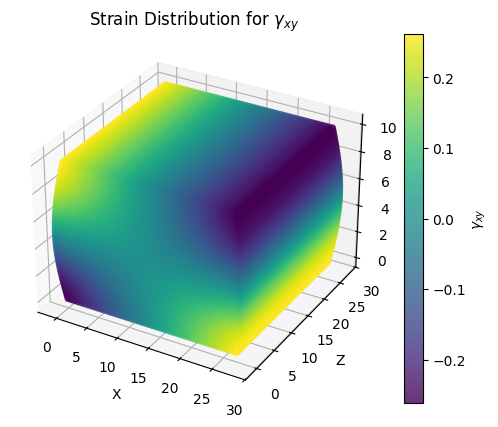

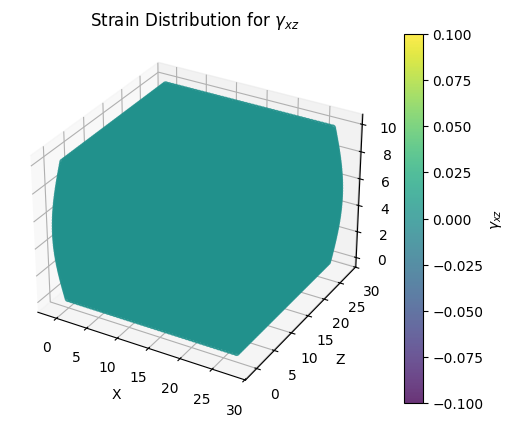

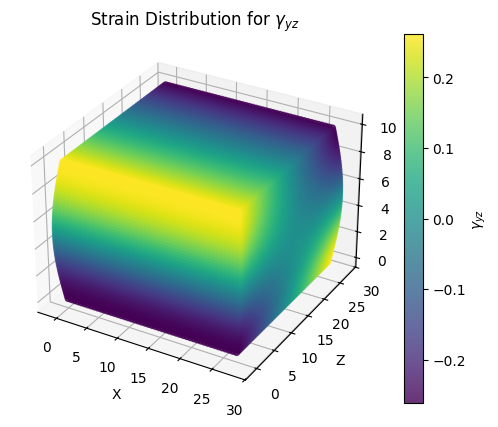

In [9]:
# List of strain components for plotting
strain_components = [
    (0, 0, r'$\epsilon_{xx}$'),
    (1, 1, r'$\epsilon_{yy}$'),
    (2, 2, r'$\epsilon_{zz}$'),
    (0, 1, r'$\gamma_{xy}$'),
    (0, 2, r'$\gamma_{xz}$'),
    (1, 2, r'$\gamma_{yz}$')
]

# Loop through each strain component to create plots
for i, j, label in strain_components:
    plt.figure()
    
    # Create a 3D subplot
    ax = plt.axes(projection='3d')

    # Create a scatter plot for each strain component
    if i == j:
        sc = ax.scatter(deformed_shape[:, 0],
                    deformed_shape[:, 2],
                    deformed_shape[:, 1],
                    c=strain_tensor[:, i, j], cmap='viridis', alpha=0.8)
    else:
        sc = ax.scatter(deformed_shape[:, 0],
                    deformed_shape[:, 2],
                    deformed_shape[:, 1],
                    c=2*strain_tensor[:, i, j], cmap='viridis', alpha=0.8)

    # Add color bar for reference
    plt.colorbar(sc, label=label)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    ax.set_title(f'Strain Distribution for {label}')

    # Show the plot
    plt.show()